# Preparations

In [1]:
import sys
import math
import copy
import itertools
import numpy as np
import collections

import scipy.stats
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
from sklearn.metrics import roc_curve

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.mlab import griddata
from matplotlib.ticker import NullFormatter
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from higgs_inference.various.utils import interpolate, format_number, asymptotic_p_value
from higgs_inference import settings


# Settings

In [184]:
# Ratio expectation recalibration
use_recalibration = False
use_separate_recalibration_sample = False

# Which benchmark point to use
use_not_trained_benchmark = True

# Which algorithm to use for the PbP vs parameterized vs morphing-aware plot
use_regression_as_pbp_param_aware_example = False  # If False, use carl

# Neyman construction settings
neyman_plots = True
remove_duplicates_for_nc = False

# Neyman observed
neyman_observed_experiment = 2

# Asymptotics settings
use_median_rather_than_asimov = False

# Interpolation
interpolation_method = 'linear' #'linear', 'gp'


In [185]:
#colors     = ['black', '0.65',  'mediumblue', '#CC002E']
#linestyles = [    '-',    ':', '-.',     '--' ]
colors     = ['0.65', 'orange',  'mediumblue', '#CC002E']
linestyles = [  '-',    ':', '-.',     '--' ]
linewidths = [1.5 if ls == ':' else 1.5 for ls in linestyles]

scatter_alpha = 1.

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb


In [186]:
thetas = np.load('../data/thetas/thetas_parameterized.npy')

n_thetas = len(thetas)
theta1 = 708
theta_observed = 0
thetas_train = list(range(17,1017))
thetas_test = list(range(17))

if use_not_trained_benchmark:
    theta_benchmark = 9
    benchmark_name = 'nottrained'
else:
    theta_benchmark = 422
    benchmark_name = 'trained'
    
pbp_training_thetas = [0, 13, 14, 15, 16, 9, 422, 956, 666, 802, 675, 839, 699, 820, 203, 291, 634, 371, 973, 742, 901, 181, 82, 937, 510, 919, 745, 588, 804, 963, 396, 62, 401, 925, 874, 770, 108, 179, 669, 758, 113, 587, 600, 975, 496, 66, 467, 412, 701, 986, 598, 810, 97, 18, 723, 159, 320, 301, 352, 159, 89, 421, 574, 923, 849, 299, 119, 167, 939, 402, 52, 787, 978, 41, 873, 533, 827, 304, 294, 760, 890, 539, 1000, 291, 740, 276, 679, 167, 125, 429, 149, 430, 720, 123, 908, 256, 777, 809, 269, 851]
basis_thetas = [0, 101, 106, 902, 910,
                226, 373, 583, 747, 841,
                599, 709, 422, 367, 167]
thetas_highlighted = []

X_observed = np.load('../data/unweighted_events/X_test.npy')


In [187]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_t_absolute_extra = 8. * 0.08
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace,
                        hspace = hspace)
    

# Define strategies and load results

In [199]:
def _load(name, folder='parameterized'):
    return np.load('../results/' + folder + '/' + name + '.npy')

def add_strategy(label, suffix, folder,
                 suffices_ensemble=None, suffix_uncalibrated=None,
                 panel=-1, in_pbp_param_aware_plot=False, in_main_plot=True, is_truth=False,
                 zorder=None, exponentiate_uncalibrated=False):
    
    neyman_string = 'neyman3' if remove_duplicates_for_nc else 'neyman2'
    
    _expected_llr = _load('llr_' + suffix, folder)
    _r_benchmark = _load('r_' + benchmark_name + '_' + suffix, folder)
    try:
        _q_thresholds = _load(neyman_string + '_qcut_' + suffix, folder)
        _q_threshold_uncertainties = _load(neyman_string + '_qcut_uncertainties_' + suffix, folder)
        _q_medians = _load(neyman_string + '_qmedian_' + suffix, folder)
    except:
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        
    labels.append(label)
    suffices.append(suffix)
    expected_llr.append(_expected_llr)
    q_medians.append(_q_medians)
    q_threshold_uncertainties.append(_q_threshold_uncertainties)
    q_thresholds.append(_q_thresholds)
    r_benchmark.append(_r_benchmark)
    
    index = len(labels) - 1
    if is_truth:
        truth_index = index
    
    print('Loaded strategy {}: {}'.format(len(labels) - 1, label))
    

In [213]:
labels = []
suffices = []
folders = []

truth_index = 0

r_benchmark = []
expected_llr = []
q_medians = []
q_thresholds = []
q_threshold_uncertainties = []

add_strategy('Truth', 'truth', 'truth')
add_strategy('Histogram', 'histo_2d', 'histo')
add_strategy('Local score regr.', 'scoreregression_rotatedscore_deep', 'score_regression')
add_strategy('CARL + score regr.', 'combined_calibrated_deep', 'parameterized')

n_strategies = len(labels)

Loaded strategy 0: Truth
Loaded strategy 1: Histogram
Loaded strategy 2: Local score regr.
Loaded strategy 3: CARL + score regr.


# Interpolation

In [214]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

interpolated_expected_llr_mle = []
interpolated_expected_llr = []

interpolated_q_medians = []
interpolated_q_thresholds = []
interpolated_cl_excluded = []

for llr in expected_llr:
        
    _interpolated_expected_llr, _mle = interpolate(thetas, llr, xx, yy,
                                                   method=interpolation_method,
                                                   subtract_min=False)
    _interpolated_expected_llr -= llr[settings.theta_observed]
        
    interpolated_expected_llr.append(_interpolated_expected_llr)
    interpolated_expected_llr_mle.append(_mle)

for i, (_q_median , _q_threshold, _q_threshold_uncertainty) in \
    enumerate(zip(q_medians, q_thresholds, q_threshold_uncertainties)):

    print('Starting strategy {} / {}'.format(i + 1, n_strategies))
    
    if _q_median is None:
        interpolated_q_medians.append(None)
        interpolated_q_thresholds.append(None)
        interpolated_cl_excluded.append(None)
        continue
        

    cut = (np.all(np.isfinite(_q_threshold),axis=1) & (np.isfinite(_q_median))
           & np.all(np.isfinite(_q_threshold_uncertainty),axis=1))

    _interpolated_q_median, _ = interpolate(thetas[cut], _q_median[cut],
                                            xx, yy,
                                            method=interpolation_method,
                                            length_scale_default=0.1, length_scale_min=0.01,
                                            length_scale_max=1.,
                                            matern_exponent=2.5,
                                            noise_level=0.01)

    _interpolated_q_thresholds = []
    for j in range(len(settings.confidence_levels)):
        _qthresh, _ = interpolate(thetas[cut], _q_threshold[cut, j], xx, yy,
                                 z_uncertainties_thetas=2*_q_threshold_uncertainty[cut, j],
                                 method=interpolation_method,
                                 length_scale_default=1., length_scale_min=0.5, length_scale_max=2.,
                                 matern_exponent=2.5,
                                 noise_level=0.01)
        _interpolated_q_thresholds.append(copy.deepcopy(_qthresh))
    _interpolated_q_thresholds = np.asarray(_interpolated_q_thresholds)

    _interpolated_cl_excluded = np.asarray([_interpolated_q_median - _interpolated_q_thresholds[j]
                                            for j in range(_interpolated_q_thresholds.shape[0])])

    interpolated_q_medians.append(_interpolated_q_median)
    interpolated_q_thresholds.append(_interpolated_q_thresholds)
    interpolated_cl_excluded.append(_interpolated_cl_excluded)


Starting strategy 1 / 4
Starting strategy 2 / 4
Starting strategy 3 / 4
Starting strategy 4 / 4


# Benchmark theta: approximate vs exact r(x)

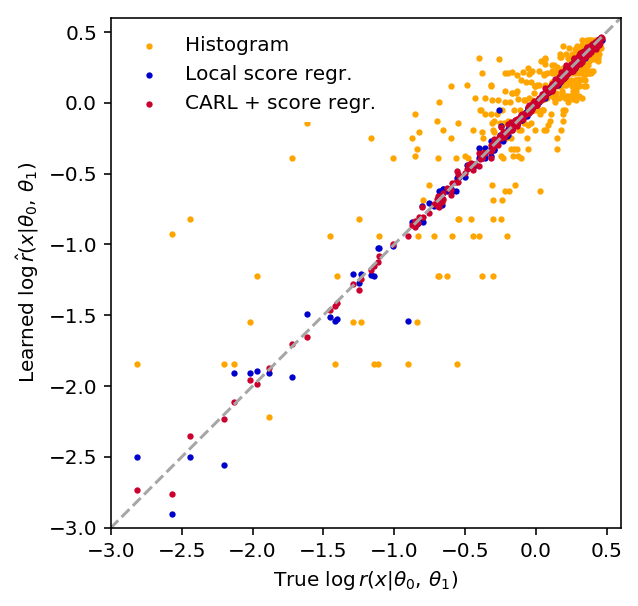

In [215]:
xmin, xmax = -3., 0.6
skip = 100

fig = plt.figure(figsize=(4.5, calculate_height(1,4.5)))
ax = plt.gca()

plt.plot([-100.,100.],[-100.,100.], ls='--', lw=1.5, c=colors[truth_index])

for s in range(n_strategies):
    if s == truth_index:
        continue
        
    plt.scatter(np.log(r_benchmark[truth_index][::skip]),
                np.log(r_benchmark[s][::skip]),
                marker='o', alpha=1., s=10., c=colors[s], lw=0.,
                label=labels[s])

plt.legend(loc='upper left', edgecolor='white', facecolor='white', framealpha=1.)

plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log \, r(x| \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \, \hat{r}(x| \theta_0,\,\theta_1)$")

adjust_margins(1,4.5)
plt.savefig("../figures/paper_short/r_scatter_small.pdf")


# Exact vs approximate expected log likelihood ratios

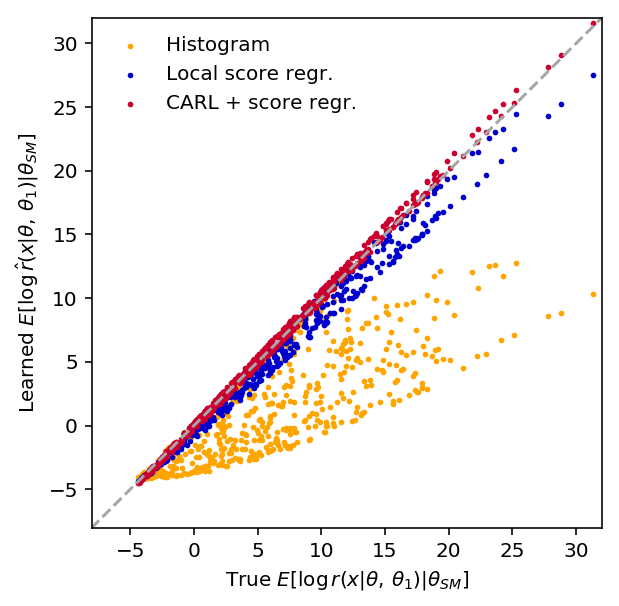

In [216]:
xmin, xmax = -8., 32.
skip = 2

fig = plt.figure(figsize=(4.5,calculate_height(1,4.5)))
ax = plt.gca()
    
plt.plot([-100.,100.],[-100.,100.], ls='--', lw=1.5, c=colors[truth_index])

for s in range(n_strategies):
    if s == truth_index:
        continue
        
    plt.scatter(expected_llr[truth_index][::skip], expected_llr[s][::skip],
                marker='o', color=colors[s], alpha=scatter_alpha, 
                s=8., lw=0.,
                label=labels[s])

plt.legend(loc='upper left', edgecolor='white', facecolor='white', framealpha=1.)

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel(r"True $E[\log \, r(x | \theta,\,\theta_1)|\theta_{SM}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(x | \theta,\,\theta_1)|\theta_{SM}]$")

adjust_margins(1,4.5)
plt.savefig("../figures/paper_short/expected_likelihood_scatter_small.pdf")


# Likelihood along diagonal

In [230]:
axis = 'diag'  # 'w', 'ww', 'diag'
y0 = 11.62 #11.62 for 3 sigma, 5.99 for 2 sigma
strategy = 3


In [231]:
def line(matrix):
    if axis == 'diag':
        return np.diag(matrix)  # f_W = f_WW
    elif axis == 'w':
        return matrix[99,:]  # f_W
    elif axis == 'ww':
        return matrix[:,99]  # f_WW
    else:
        raise ValueError()

In [232]:
# Grid
xi = np.linspace(-1.0, 1.0, 200)

x0 = []
y1 = []
for s in range(n_strategies):
    for i, y in enumerate(line(interpolated_expected_llr[s])):
        if y < y0:
            x0.append(0.5 * (xi[i-1] + xi[i]))
            if s == strategy:
                for ss in range(n_strategies):
                    _y = line(interpolated_expected_llr[ss])
                    y1.append(0.5 * (_y[i-1] + _y[i]))
            break
            
reach_factor = (x0[1] / x0[strategy])**0.5
luminosity_factor = (y1[strategy]/y1[1])
print(reach_factor, luminosity_factor, reach_factor**4)
        

1.1500350625790894 1.7996768397448348 1.7492195629552543


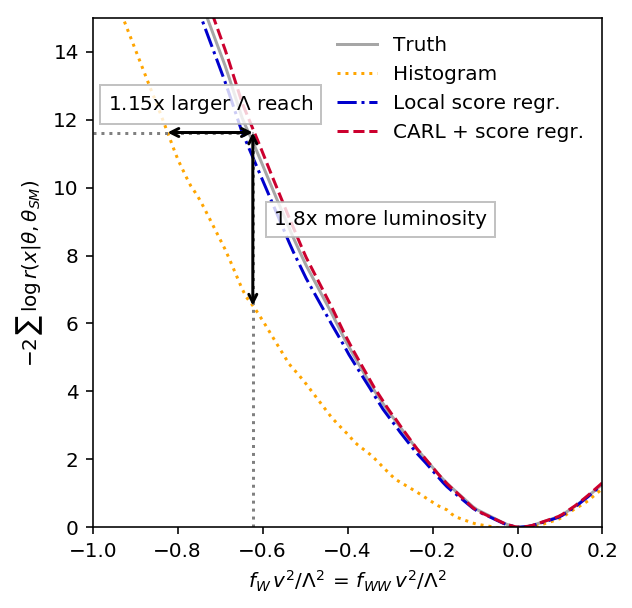

In [233]:
# Grid
xi = np.linspace(-1.0, 1.0, 200)

fig = plt.figure(figsize=(4.5,calculate_height(1,4.5)))
ax = plt.gca()
    
for s in [0,1,2,strategy]:
    yi = line(interpolated_expected_llr[s])
    plt.plot(xi, yi,
             lw=linewidths[s], color=colors[s], ls=linestyles[s],
             label=labels[s])
    
plt.plot([-1.,x0[strategy]], [y0, y0], color='0.5', ls=':', lw=1.5)
plt.plot([x0[strategy], x0[strategy]], [0., y0], color='0.5', ls=':', lw=1.5)

plt.annotate(s='',
             xy=(x0[1], y0,),
             xytext=(x0[strategy], y0),
             arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0, lw=1.5))
plt.annotate(s='',
             xy=(x0[strategy], y1[1],),
             xytext=(x0[strategy], y0),
             arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0, lw=1.5))

t = plt.text(0.5*(x0[1] + x0[strategy]), y0 + 0.5,
             '{0:.2f}x larger $\Lambda$ reach'.format(reach_factor),
             va='bottom', ha='center')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='0.7'))
t = plt.text(x0[strategy] + 0.05, 0.5*(y0 + y1[1]),
         '{0:.1f}x more luminosity'.format(luminosity_factor),
         va='center', ha='left')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='0.7'))

# Legend
plt.legend(loc='upper right', frameon=False)

# Axis details
plt.xlim(-1., 0.2)
if y0 < 10.:
    plt.ylim(0., 10.)
else:
    plt.ylim(0., 15.)
if axis=='w':
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
elif axis=='ww':
    plt.xlabel(r"$f_{WW} \, v^2 / \Lambda^2$")
elif axis=='diag':
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2 \, = \, f_{WW} \, v^2 / \Lambda^2$")
plt.ylabel(r"$-2 \, \sum \, \log \, r(x | \theta, \theta_{SM})$")

adjust_margins(1,4.5)
plt.savefig("../figures/paper_short/llr_example_small.pdf")


## Expected CL contours from Neyman construction

TypeError: 'NoneType' object is not subscriptable

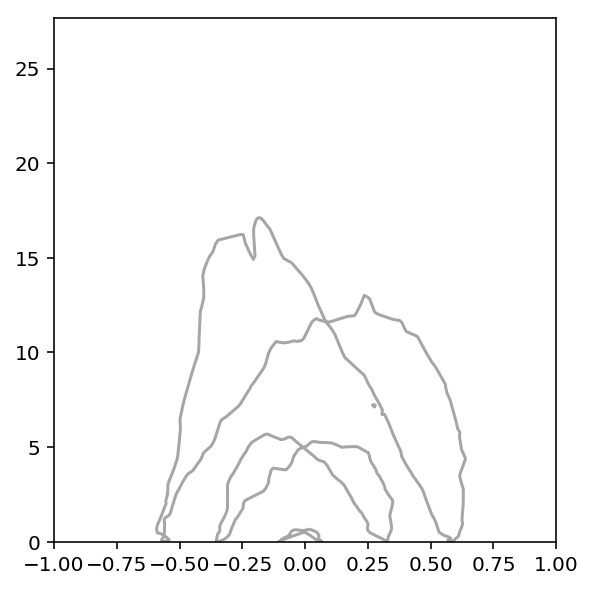

In [221]:
fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,1,True)))
ax = plt.gca()

for s in range(n_strategies):

    for cl in range(len(interpolated_cl_excluded[truth_index])):
        cs = plt.contour(xi, yi, interpolated_cl_excluded[s][cl], [0.],
                         linewidths=linewidths[s], colors=colors[s],
                         linestyles=linestyles[s])
        if cl==0:
            cs.collections[0].set_label(labels[s])

plt.legend(loc='lower left', bbox_to_anchor=(-0.02,0.99), frameon=False, ncol=2)

plt.xlim(-1, 1.)
plt.ylim(-1, 1.)
plt.xticks(np.linspace(-1.,1.,5))
plt.yticks(np.linspace(-1.,1.,5))
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")

adjust_margins(1,4.5,1,True)
plt.savefig("../figures/paper_short/constraints_small.pdf")


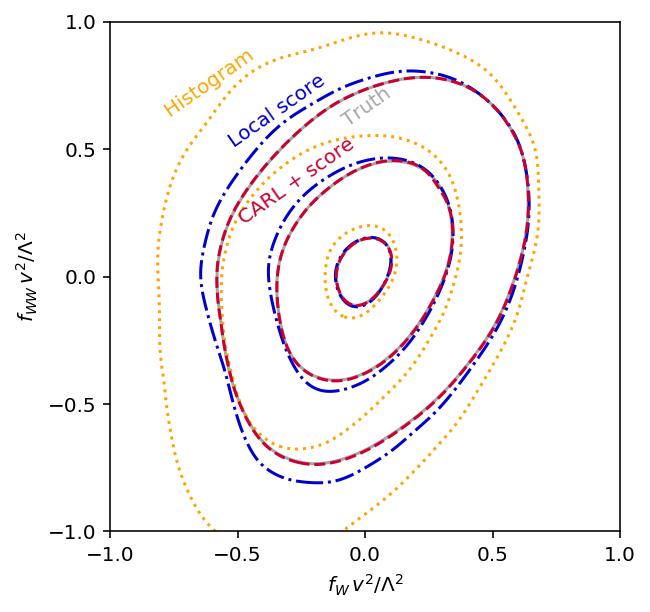

In [74]:
label_pos = [(-0.1,0.7),
             (-0.8,0.85),
             (-0.55,0.75),
             (-0.51,0.5)]
rotations=[35.,35.,35.,35.]
vmin, vmax = 0., 30.
labels_here = ['Truth', 'Histogram', 'Local score', 'CARL + score']

fig = plt.figure(figsize=(4.5,calculate_height(1,4.5)))
ax = plt.gca()

for s in range(n_strategies):

    for cl in range(len(interpolated_cl_excluded[truth_index])):
        cs = plt.contour(xi, yi, interpolated_cl_excluded[s][cl], [0.],
                         linewidths=linewidths[s], colors=colors[s],
                         linestyles=linestyles[s])
        if cl==0:
            cs.collections[0].set_label(labels[s])
            
    plt.text(label_pos[s][0], label_pos[s][1], labels_here[s], color=colors[s], rotation=rotations[s])

plt.xlim(-1, 1.)
plt.ylim(-1, 1.)
plt.xticks(np.linspace(-1.,1.,5))
plt.yticks(np.linspace(-1.,1.,5))
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")

adjust_margins(1,4.5)
plt.show()


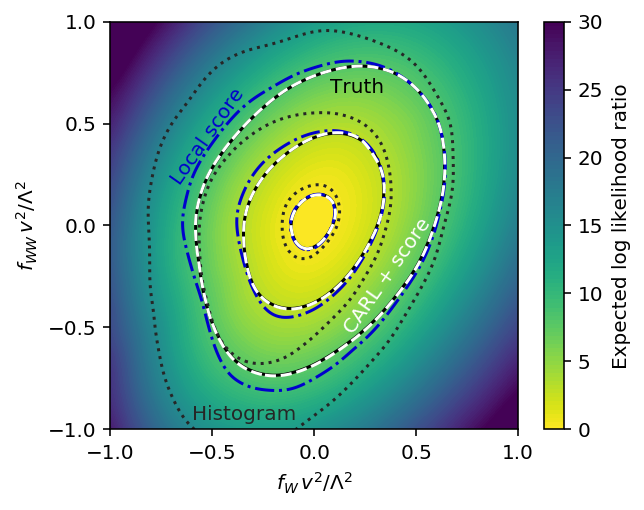

In [75]:
label_pos = [(0.08,0.65),
             (-0.6,-0.95),
             (-0.72,0.62),
             (0.13,-0.02)]
rotations=[0.,0.,55.,55.]
vmin, vmax = 0., 30.
colors_here = ['black', '0.15', 'mediumblue', 'white']
labels_here = ['Truth', 'Histogram', 'Local score', 'CARL + score']

fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,1.25)))
ax = plt.gca()

cs = plt.contourf(xi, yi, np.clip(interpolated_expected_llr[3],vmin,vmax), 100, vmin=vmin,vmax=vmax, cmap='viridis_r')
cbar = plt.colorbar(ticks=np.linspace(0.,30.,7))

for s in range(n_strategies):

    for cl in range(len(interpolated_cl_excluded[truth_index])):
        cs = plt.contour(xi, yi, interpolated_cl_excluded[s][cl], [0.],
                         linewidths=linewidths[s], colors=colors_here[s],
                         linestyles=linestyles[s])
        if cl==0:
            cs.collections[0].set_label(labels[s])
            
    plt.text(label_pos[s][0], label_pos[s][1], labels_here[s], color=colors_here[s], rotation=rotations[s])

# plt.legend(loc='lower left', bbox_to_anchor=(-0.02,0.99), frameon=False)

plt.xlim(-1, 1.)
plt.ylim(-1, 1.)
plt.xticks(np.linspace(-1.,1.,5))
plt.yticks(np.linspace(-1.,1.,5))
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'Expected log likelihood ratio')

adjust_margins(1,4.5,1.25)
plt.show()
